<img src="image.png" style="width:350px;height:70pz"/>

# International Project
## Use of a MOSFET Digital Twin using Deep Learning Methods
### Instructor: Lynn Houthuys 👩‍🏫
### Author: Ηenri Xhindi 👨‍🎓

### Purpose of work 📚
Τhis work demostrates the potential of digital twins in the industry as well as how they can be simulated and trained with A.I. methods. 
Digital twin modeling does not necessarily need tools from data science or machine learning. However, it is prudent to use such modeling techniques wherever applicable and suitable. In our case we will make a digital twin of a MOSFET and later on we will use Deep Learning models on it. The target of this work is that by creating the digital twin, it can allows you to swap out an analytical model with an Machine Learning model (and vice versa).

More precisely, with using an ML technique, we are going to predict the  Sub-Threshold leakage of a MOSFET, a phenomenon found in all MOSFETs. Later on, it is going to get discussed with more details.



## A little bit of theory 🤓

#### Digital Twins  🤖🤖

Digital twins can be digital replicas-representations of physical objects, processes or services of the physical world, such as jet engines, wind farms, or even larger items such as buildings or even whole cities.
As well as physical assets, digital twin objects can be used to replicate processes in order to collect data to predict how they will perform.

#### Deep Learning 🧠

Deep learning is a type of machine learning based on artificial neural networks that imitates the way humans gain certain types of knowledge. Deep learning is an important element of data science, which includes statistics and predictive modeling. We will use Deep Learning methods on this project in ourder to train our digital twin.

#### MOSFET  🖥️

Transistors are semiconductor devices used to amplify or switch electrical signals and power. Also, they are one of the basic building blocks of modern electronics.
Most modern transistors are Metal-Oxide-Semiconductor Field-Effect-Transistor (MOSFET). Basically, MOSFET is a device made of metal and semiconductor layers (usually silicon-Si or germanium-Ge) that sandwich an electrical insulator material layer in between (usually a thin oxide).

<img src="MOSFET_Structure.png" style="width:350px;height:70pz"/>


Practically the MOSFET is a digital switch.To be more precise, if the voltage between Gate (G) and Source (S) is below a certain threshold, then the switch is OFF (0-zero) and no current flows between the Drain and Source. In contrary when the Gate (G) to Source (S) voltage is above this threshold, the switch is ON (1-one). Furthermore, the Drain (D) to Source (S) current is also determined by the voltage between them.
So, the fundamental utility of a MOSFET is as a voltage-controlled switch i.e. we can control the amount of current (or information) between two of its terminals by controlling the voltage on the third terminal.

### Characteristics we want to model


When developing a digital twin, the characteristics we should consider is one of the most important parts of the development. This determines the complexity and data structure choice for our digital twin.

In our project, for the sake of simplicity, we will consider modeling only the most bacics charecteristics. Although we can model all kinds of complex physics phenomena with the MOSFET structure, we will work with the drain-source current (Ids) and voltage (Vds) relationships in their simplest form.



## Let the coding begin 👨‍💻

#### Importing the necessary libraries 📕

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline

#### Definition of constant - fixed parameters ⚡

In [2]:
# Function for sub-Vth(threshold leakage) calculation
def sub_vth(W_L,Vgs,Vth,temp=300):
    
    # Initialization of parameters to simulate the measurement noise and manufacturing/material variability

    # Electron charge
    q = 1.60218e-19
    
    # Boltzman constant
    k = 1.3806e-23
    
    
    
    # W_L & eta gets randomized to mimic material and manufacturing variability
    # We are using the numpy library in order to achive that. 
    
    # Capacitance factor
    eta = 1.2+0.01*np.random.normal()
    
    # Mobility factor/coefficient
    W_L = W_L*(1+0.01*np.random.normal())
    
    
    return W_L*np.exp(q*(Vgs-Vth)/(eta*k*temp))

#### Declaration of MOSFET class 📟

In [3]:
class MOSFET:
    def __init__(self,params=None,terminals=None):
          
        """
        The followings parameters are considered some of the most important parameters
        of a generic MOSFET.
    
        Vth --> The threshold voltage between Gate and Source of the MOSFET in which is ON
        gm  --> The convenience of the MOSFET to carry current between Drain and Source when it's ON
        BV  --> The breakdown voltage shows how much voltage the MOSFET can hold between its Drain 
        and Source while it is in the OFF state.    
        """
        
        # Params
        if params is None:
            self._params_ = {'BV':20,
                             'Vth':1.0,
                             'gm':1e-2}
        else:
            self._params_ = params
            
            
        
        # Terminals
        if terminals is None:
            self._terminals_ = {'Source':0.0,
                        'Drain':0.0,
                        'Gate':0.0}
        else:
            self._terminals_ = terminals
            
        
        # Determine state
        self._state_ = self.determine_state()
        
        # Leakage model trained?
        self._leakage_ = False
        self.leakage_model = None
        
#-------------------------------------------------------------------------
## With the following method we can describe the object in one line.

    def __repr__(self):
        return "MOSFET's Digital Twin"

    
#-------------------------------------------------------------------------    
## With the following method we can determine the Switching State (ON/OFF) of the MOSFET.

    def determine_state(self,Vgs=None):

        if Vgs is None:
            Vgs = self._terminals_['Gate'] - self._terminals_['Source']
        else:
            Vgs = Vgs
        if Vgs > self._params_['Vth']:
            return 'ON'
        else:
            return 'OFF'

        
#-------------------------------------------------------------------------    
## Calculation of the Drain-Source Current of the MOSFET using the terminal voltages and gm.

    def Id_Vd(self,Vgs=None,Vds=None,rounding=True):
       
        if Vds is None:
            Vds = self._terminals_['Drain'] - self._terminals_['Source']
        else:
            Vds = Vds
        if Vgs is None:
            Vgs = self._terminals_['Gate'] - self._terminals_['Source']
        else:
            Vgs = Vgs
        
        Vth = self._params_['Vth']
        state = self.determine_state(Vgs=Vgs)
        self._state_ = state
        
        if state=='ON':
            if Vds <= Vgs - Vth:
                Ids = self._params_['gm']*(Vgs - Vth - (Vds/2))*Vds
            else:
                Ids = (self._params_['gm']/2)*(Vgs-Vth)**2
            if rounding:
                return round(Ids,3)
            else:
                return Ids
        else:
            return sub_vth(W_L=self._params_['gm'],
                           Vgs=Vgs,
                           Vth=Vth)
        

#-------------------------------------------------------------------------    
## Calculates Rdson i.e. on-state resistance of the MOSFET


    def rdson(self,Vgs=None,Vds=None):

        if Vds is None:
            Vds = self._terminals_['Drain'] - self._terminals_['Source']
        else:
            Vds = Vds
        if Vgs is None:
            Vgs = self._terminals_['Gate'] - self._terminals_['Source']
        else:
            Vgs = Vgs
        
        Ids = self.Id_Vd(Vgs=Vgs,Vds=Vds,rounding=False)
        Vds_delta = Vds+0.001
        Ids_delta = self.Id_Vd(Vgs=Vgs,Vds=Vds_delta,rounding=False)
        rdson = 0.001/(Ids_delta-Ids)
        
        return round(rdson,3)
    
    
#-------------------------------------------------------------------------    
## Training of our model with Deep Learning 
## Now we are going to train the digital twin as a model with leakage current using experimental data.


    def train_leakage(self,data=None,
                      batch_size=5,
                      epochs=20,
                      learning_rate=2e-5,
                      verbose=1):

        """
            data          --> the training data (Pandas DataFrame)
            batch_size    --> training batch size
            epochs        --> No. of epochs 
            learning_rate --> learning rate 
            verbose       --> verbosity of display while training
        """
                                    
        if data is None:
            return "No data available for training"
        X_train_scaled, X_test_scaled, \
        y_train_scaled, y_test_scaled = prepare_data(data,
                                                input_cols=['W_L','Vgs','Vth'],
                                                output_var='log-leakage',
                                                        scaley=False)
        
        # Deep-learning model
        model = build_model(num_layers=3,
                            architecture=[32,32,32],
                            input_dim=3)
        
        # Compile and train
        model_trained = compile_train_model(model,
                                            X_train_scaled,
                                            y_train_scaled,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            learning_rate=learning_rate,
                                            verbose=verbose)
        
        self.leakage_model = model_trained
        self._leakage_ = True
                        
                      
#-------------------------------------------------------------------------                      
## Separate leakage method to predict the sub-Vth leakage for any combination of transconductance, Vgs, and Vth as input.

    def leakage(self,
                W_L=1e-2,
                Vgs=None,
                Vth=None):
                      
        """
        Calculates leakage current using the deep learning model
        """
                      
        if not self._leakage_:
            return "Leakage model is not trained"
        # Vgs
        if Vgs is None:
            Vgs = self._terminals_['Gate'] - self._terminals_['Source']
        else:
            Vgs = Vgs
        # Vth
        if Vth is None:
            Vth = self._params_['Vth']
        else:
            Vth = Vth
        # Predict
        x = np.array([W_L,Vgs,Vth])
        ip = x.reshape(-1,3)
        result = float(10**(-self.leakage_model.predict(ip)))
        
        
        return result

# CREATING A MOSFET OBJECT

In [4]:
mosfet = MOSFET()


In [5]:
mosfet


MOSFET's Digital Twin

In [6]:
mosfet._state_


'OFF'

In [7]:
mosfet._params_


{'BV': 20, 'Vth': 1.0, 'gm': 0.01}

### Object state changes as terminal voltage assignment varies

In [8]:
mosfet = MOSFET(terminals={'Source':0.0,
            'Drain':0.0,
            'Gate':2.0}, 
           params={'BV':20,
                   'Vth':1.0,
                   'gm':1e-2})

In [9]:
mosfet._state_


'ON'

In [10]:
mosfet = MOSFET(terminals={'Source':0.0,
            'Drain':0.0,
            'Gate':0.7},
            params={'BV':20,
                   'Vth':1.0,
                   'gm':1e-2})

In [11]:
mosfet._state_


'OFF'

## Declaring Id-Vd values for the MOSFET

In [12]:
# Drain-Source Current
mosfet.Id_Vd(Vgs=0.2,Vds=2.0)

6.938870708960422e-14

In [13]:
# Drain-Source Current
mosfet.Id_Vd(Vgs=3.0,Vds=0.5)

0.009

In [14]:
# Drain-Source Current
mosfet.Id_Vd(Vgs=3.0,Vds=1.0)

0.015

In [15]:
# Drain-Source Current
mosfet.Id_Vd(Vgs=3.0,Vds=3.0)

0.02

In [16]:
# Drain-Source Current
mosfet.Id_Vd(Vgs=3.0,Vds=4.0)

0.02

In [17]:
mosfet._state_

'ON'

In [18]:
# On-state Resistance
mosfet.rdson(Vgs=3.0,Vds=0.5)

66.689

In [19]:
# On-state Resistance
mosfet.rdson(Vgs=3.0,Vds=0.6)

71.454

In [20]:
# On-state Resistance
mosfet.rdson(Vgs=5.0,Vds=1.5)

40.008

## Current (Ids) - Voltage (Vds) Graph Characteristics

- For an ideal MOSFET 

In [21]:
Ids = []
mosfet = MOSFET()
Vds_vals = [0.01*i for i in range(1,501)]
for V in Vds_vals:
    Ids.append(mosfet.Id_Vd(Vgs=3.0,Vds=V,rounding=False))

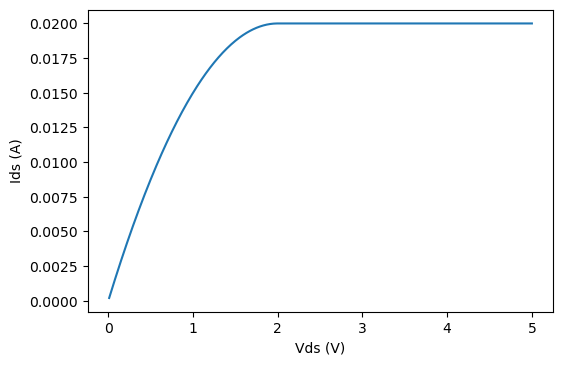

In [22]:
plt.figure(dpi=100)
plt.plot(Vds_vals,Ids)
plt.xlabel("Vds (V)",fontsize=10)
plt.ylabel("Ids (A)",fontsize=10)
plt.show()

- Graph of a more analytical model which contains Vgs (Voltage of Gate-Source).

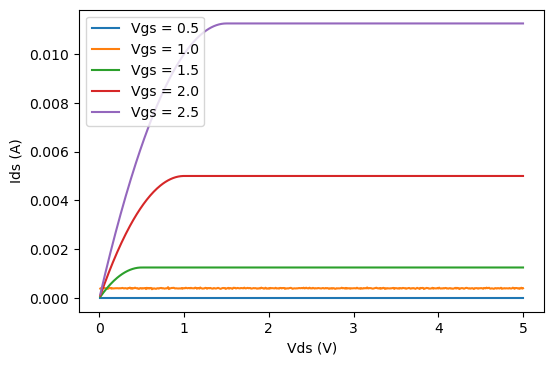

In [23]:
m = MOSFET()
plt.figure(dpi=100)
for Vgs in [0.5,0.9,1.5,2.0,2.5]:
    Ids = []
    Vds_vals = [0.01*i for i in range(1,501)]
    for V in Vds_vals:
        Ids.append(m.Id_Vd(Vgs=Vgs,Vds=V,rounding=False))
    plt.plot(Vds_vals,Ids)
plt.legend(["Vgs = "+str(V) for V in [0.5,1.0,1.5,2.0,2.5]])
plt.xlabel("Vds (V)",fontsize=10)
plt.ylabel("Ids (A)",fontsize=10)
plt.show()

## Importing the Sub-Vth leakage of a MOSFET

The ideal MOSFET, when in OFF state (Vgs is below Vth), must carry zero current between Drain & Source. However, in the reality, due to quantum mechanics, a real MOSFET carries a small amount of ‘leakage’ current even in the OFF state.

For that case, we are going to calculate this current using a DNN (deep neural network).



In [24]:
mosfet.train_leakage()


'No data available for training'

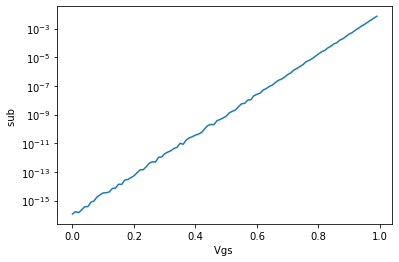

In [25]:
sub = []
Vgs = []
for i in range(100):
    sub.append(sub_vth(W_L=1e-2,Vgs=i*0.01,Vth=1.0))
    Vgs.append(i*0.01)

plt.semilogy(Vgs,sub)
plt.xlabel("Vgs ",fontsize=10)
plt.ylabel("sub ",fontsize=10)
plt.show()

## Importing Synthetic leakage data

In [26]:
from itertools import product

In [27]:
W_L_list = [1e-3*i for i in range(1,21)]
Vgs_list = [0.01*i for i in range(1,91)]
Vth_list = [0.05*i for i in range(21,31)]

In [28]:
comb = list(product(W_L_list,Vgs_list,Vth_list))


In [29]:
data_dict = {'W_L':[],'Vgs':[],'Vth':[],'sub-Vth':[]}
for c in comb:
    data_dict['W_L'].append(c[0])
    data_dict['Vgs'].append(c[1])
    data_dict['Vth'].append(c[2])
    data_dict['sub-Vth'].append(sub_vth(c[0],c[1],c[2]))

In [30]:
df = pd.DataFrame(data=data_dict,columns=['W_L','Vgs','Vth','sub-Vth'])


In [44]:
df.sample(7).T


,11584,15839,6004,12030,11808,1913,3602
W_L,1.300000e-02,1.800000e-02,7.000000e-03,1.400000e-02,1.400000e-02,3.000000e-03,5.000000e-03
Vgs,7.900000e-01,5.400000e-01,6.100000e-01,3.400000e-01,1.100000e-01,1.200000e-01,1.000000e-02
Vth,1.250000e+00,1.500000e+00,1.250000e+00,1.050000e+00,1.450000e+00,1.200000e+00,1.150000e+00
sub-Vth,4.203874e-09,9.587587e-16,8.137293e-12,1.471124e-12,1.910744e-21,4.712638e-18,5.133246e-19
log-leakage,8.376350e+00,1.501829e+01,1.108952e+01,1.183235e+01,2.071880e+01,1.732674e+01,1.828961e+01


In [47]:
df.shape


(18000, 5)

In [32]:
df['log-leakage'] = -np.log10(df['sub-Vth'])


## Training leakage model 🏋️

#### Deep Neural Network Creation 🧠

In [33]:
def prepare_data(df, input_cols,output_var,test_size=0.3,scaley=False):

    df1 = df.copy()
    X = df1[input_cols]
    y = df1[str(output_var)]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Min-max scaler from Scikit-learn
    scalerx = MinMaxScaler()
    scalery = MinMaxScaler()
    X_train_scaled = scalerx.fit_transform(X_train)
    X_test_scaled = scalerx.fit_transform(X_test)
    if scaley == True:
        y_train_scaled = scalery.fit_transform(y_train.values.reshape(-1, 1))
        y_test_scaled = scalery.fit_transform(y_test.values.reshape(-1, 1))
    else:
        y_train_scaled = y_train.values.reshape(-1, 1)
        y_test_scaled = y_test.values.reshape(-1, 1)
    
    return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)


#  Builds a DNN model from user input
def build_model(num_layers=1, architecture=[32],act_func='relu', 
                input_dim=2, output_class=10):
    
  """
  num_layers   --> Number of hidden layers
  architecture --> Architecture of the hidden layers (densely connected)
  act_func     --> Activation function ('relu','sigmoid','tanh')
  input_shape  --> Dimension of the input vector
  output_class --> Number of classes in the output vector
  """

  layers=[tf.keras.layers.Dense(input_dim,input_dim=input_dim)]
  if act_func=='relu':
    activation=tf.nn.relu
  elif act_func=='sigmoid':
    activation=tf.nn.sigmoid
  elif act_func=='tanh':
    activation=tf.nn.tanh
    
  for i in range(num_layers):
    layers.append(tf.keras.layers.Dense(architecture[i], activation=tf.nn.relu))
  layers.append(tf.keras.layers.Dense(1))
  
  model = tf.keras.models.Sequential(layers)
  return model


#  Compiles and trains a given Keras model with the given data. 
def compile_train_model(model,x_train, y_train, callbacks=None,
                        learning_rate=0.001,batch_size=1,epochs=10,verbose=0):
    
  """
  learning_rate --> Learning rate for the optimizer Adam
  batch_size    --> Batch size for the mini-batch optimization
  epochs        --> Number of epochs to train
  verbose       --> Verbosity of the training process
  """
  
  model_copy = model
  model_copy.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                     loss="mse", metrics=["mse"])
  
  if callbacks is not None:
        model_copy.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                 callbacks=[callbacks],verbose=verbose)
  else:
    model_copy.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                   verbose=verbose)
  return model_copy

With the following arrangement, we just write one line of code to train the model with the training data supplied as df DataFrame.

In [34]:
mosfet.train_leakage(df)


2022-06-15 11:27:25.566669: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-06-15 11:27:25.595374: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2095915000 Hz
2022-06-15 11:27:25.596156: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f1c2f6d6d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-15 11:27:25.596201: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-15 11:27:25.596396: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Train on 12600 samples
Epoch 1/20
12600/12600 [==============================] - 11s 908us/sample - loss: 186.1212 - mse: 186.1212
Epoch 2/20
12600/12600 [==============================] - 11s 853us/sample - loss: 80.4876 - mse: 80.4876
Epoch 3/20
12600/12600 [==============================] - 13s 1ms/sample - loss: 33.3332 - mse: 33.3332
Epoch 4/20
12600/12600 [==============================] - 12s 913us/sample - loss: 27.2209 - mse: 27.2209
Epoch 5/20
12600/12600 [==============================] - 12s 934us/sample - loss: 23.0494 - mse: 23.0494
Epoch 6/20
12600/12600 [==============================] - 13s 1ms/sample - loss: 18.8462 - mse: 18.8462
Epoch 7/20
12600/12600 [==============================] - 12s 944us/sample - loss: 14.2675 - mse: 14.2675
Epoch 8/20
12600/12600 [==============================] - 12s 920us/sample - loss: 9.1957 - mse: 9.1957
Epoch 9/20
12600/12600 [==============================] - 13s 1ms/sample - loss: 4.3629 - mse: 4.3629
Epoch 10/20
12600/12600 [======

In [35]:
m1_trained = mosfet.leakage_model


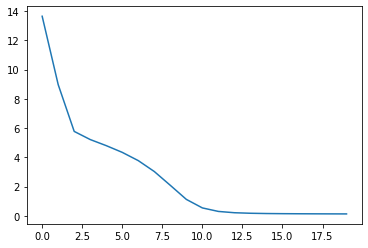

In [36]:
plt.plot(np.sqrt(m1_trained.history.history['mse']))
plt.show()


In [37]:
mosfet.leakage()


2.8572100224998124e-24

In [38]:
mosfet.leakage(W_L=1e-1,Vgs=0.75)


7.467522931123901e-15

In [39]:
mosfet._terminals_['Gate']=0.8


In [40]:
mosfet.leakage(W_L=1)


4.234763310417139e-13

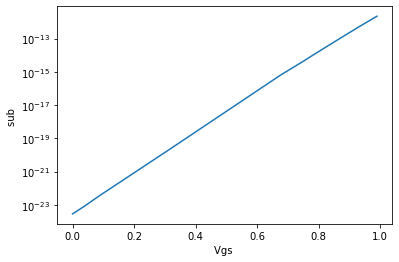

In [41]:
sub = []
Vgs = []
for i in range(100):
    sub.append(mosfet.leakage(W_L=1e-2,Vgs=i*0.01,Vth=1.0))
    Vgs.append(i*0.01)

plt.semilogy(Vgs,sub)
plt.xlabel("Vgs ",fontsize=10)
plt.ylabel("sub ",fontsize=10)
plt.show()

In [42]:
m = MOSFET(terminals={'Source':0.0,
            'Drain':0.0,
            'Gate':0.7})

In [43]:
mosfet.leakage()

1.6688959716677602e-14

### Sources📕

https://towardsdatascience.com/digital-twin-with-python-a-hands-on-example-2a3036124b61

https://www.twi-global.com/technical-knowledge/faqs/what-is-digital-twin

https://en.wikipedia.org/wiki/MOSFET

https://www.electronics-tutorials.ws/transistor/tran_6.html